-0.00311303138733
starting the Fourier step
-0.0510048866272
done speckle generation, now calculate specke amplitude
-0.0743999481201
next add poission noise
-0.107486009598
starting to plot the result


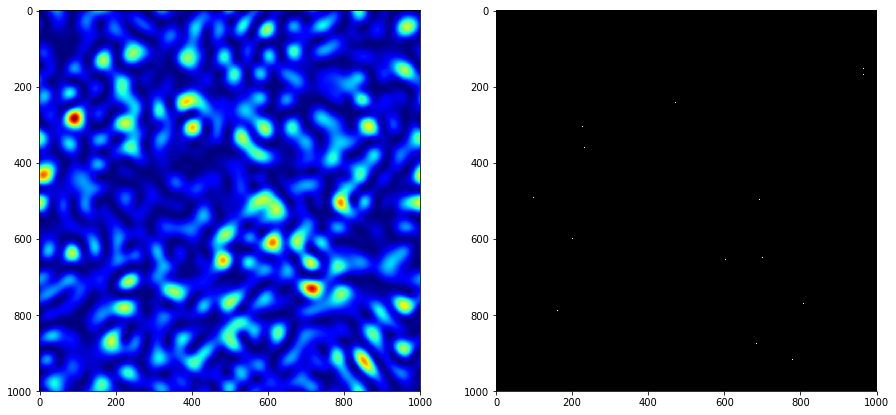

105


' FFT step seems to be taking most of the time, with adding shot noise as the next\ncomputing heavy step.'

In [119]:
import numpy as np
import time
from matplotlib import pyplot as plt

# this segment plays with the basics of generating speckle patterns of different contrast with noise

side = 1000
image = np.zeros([side,side])
speckleSize = 50 # 30 will lead to a factof of 3 over sampling, thus better maintain the contrast
xPhasors = int(np.round(side/speckleSize))
yPhasors = int(np.round(side/speckleSize))
phasor = np.zeros([side,side],dtype = complex)

tic = time.time()
for i in range(xPhasors):
    for j in range(yPhasors):
        phase = np.random.random()*2*np.pi*1j
        phasor[i,j] = np.exp(phase)
toc = time.time();print tic-toc

print("starting the Fourier step")
speckle = np.fft.fft2(phasor)
toc = time.time();print tic-toc
print("done speckle generation, now calculate specke amplitude")
speckle = [np.abs(elt)**2 for elt in speckle]
speckle /= np.max(speckle)
toc = time.time();print tic-toc
print("next add poission noise")
temp = AddShotNoise(speckle,0.0001);
toc = time.time();print tic-toc

# this section seems to be taking quite some time, mostly from the FFT

#poisson = poissonNoise(noiseSize,side)
#speckle += poisson

#Add 2 uncorrelated patterns together to get 0.5 contrast
#Simulate charge cloud: we need better resolution than the detector size
# do for example 1000x1000 and then finally get 200x200 when I digitize.
# Speckle size should also be bigger than the 5x5 detector size.

print("starting to plot the result")
plt.figure(figsize=[15,10])
plt.subplot(1,2,1)
plt.imshow(speckle, cmap='jet')
plt.subplot(1,2,2)
plt.imshow(temp, cmap = 'gray')
plt.show()
print(sum(temp.flatten()))

""" FFT step seems to be taking most of the time, with adding shot noise as the next
computing heavy step."""

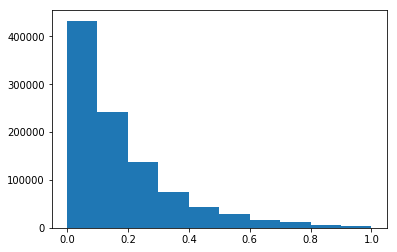

In [271]:
# showing the nagative binomial distribution of a M=1 speckle pattern
plt.hist(speckle.flatten());

In [569]:
#https://math.stackexchange.com/questions/316175/probability-to-choose-specific-item-in-a-weighted-sampling-without-replacement#320640
# define some functions as building blocks

from ast import literal_eval as make_tuple
from scipy import ndimage



def makePhotons(nPhotons):
    """here the use of np.random.choice does not seem correct"""
    speckleLabels = [["({},{})".format(j,i) for i in range(np.shape(speckle)[0])] for j in range(np.shape(speckle)[1])]
    speckleLabels = [elt for row in speckleLabels for elt in row] # Flatten
    flatSpeckle = np.reshape(speckle,np.shape(speckle)[0]*np.shape(speckle)[1]) # Flatten
    flatSpeckle /= np.sum(flatSpeckle) # Normalize
    # I see that this formalism comes from Fivos's example on github,
    # but here is a misunderstanding in what p is.
    choices = np.random.choice(speckleLabels,nPhotons, p=flatSpeckle)

    photons = np.zeros(np.shape(speckle))
    for elt in choices:
        tup = make_tuple(elt)
        photons[tup[0],tup[1]] = 1 # Or assign some number to phton to electron-photon conversion. So use 
    
    return photons

"""
when photons are absorbed in silicon sensors and turns into electrons, there is a conversion rate.
Every 3.6 eV turns into 1 electron. For example, 360 eV photon will turn into 100 electrons and 7.2 keV
photon will turn into about 2000 electrons. The process of course is not fully deterministic and there
are many other sources of uncertainties and electron/charge loss mechanisms.
"""

def makeSpeckle(size, speckleSize):
    image = np.zeros(size)
    speckleSize = 50 # 30 will lead to a factof of 3 over sampling, thus better maintain the contrast
    xPhasors = int(np.round(size[0]/speckleSize))
    yPhasors = int(np.round(size[1]/speckleSize))
    rndPhasor = np.zeros(size)
    rndPhasor[0:xPhasors,0:yPhasors] = np.exp(np.random.random([xPhasors,yPhasors])*2.j*np.pi)
    speckleField = np.fft.fft2(rndPhasor)
    speckleIntensity = np.abs(speckleField)**2
    return speckleIntensity/np.mean(speckleIntensity.flatten())


def AddShotNoise(speckle, kbar):
    """
    generate speckle pattern as descrete photons by introducing shot noise.
    variable kbar is the average photon density over the field of view.
    """
    speckle = speckle/np.mean(speckle.flatten())*kbar;
    return np.random.poisson(speckle)

def ApplyChargeCloud(photonPattern, cloudSize, photonEnergy):
    """
    this step blurrs the photon map by the charge cloud size, assuming
    every electron in silicon takes 3.6 eV to generate.
    """
    return ndimage.filters.gaussian_filter(photonPattern*photonEnergy/3.6, cloudSize/2.35, mode='wrap', truncate=7)

def rebin(a, shape):
    """
    pattern rebinning down to smaller sizes
    by adding MXN blocks together.
    """
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).sum(-1).sum(1)

def rebin_slow(a, scale):
    aNew = np.zeros([a.shape[0]/scale, a.shape[1]/scale])
    for i in range(speckle.shape[0]/scale):
        for j in range(speckle.shape[1]/scale):
            aNew[i,j]=sum(sum(a[i*scale:i*scale+scale, j*scale:j*scale+scale]))
            
    return aNew
            

def digitizeCharge(chargePattern, chargePerADU=15):
    """
    digitize the charge pattern to ADUs
    """
    return chargePattern/chargePerADU

    
def AddReadoutNoise(chargePattern, pixelReadoutNoise):
    """
    add readout noise to the detector.
    """
    return chargePattern + np.random.randn(chargePattern.shape[0], chargePattern.shape[1])*pixelReadoutNoise


In [536]:
a = np.random.randn(10,10)
b = ndimage.filters.gaussian_filter(a, 3, mode='wrap', truncate=7)
print(sum(a.flatten()))
print(sum(b.flatten()))

-4.29815806317
-4.29815806317


/Users/dlzhu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part


1.07697105408
34
34.0
34.0
34.0
34.0


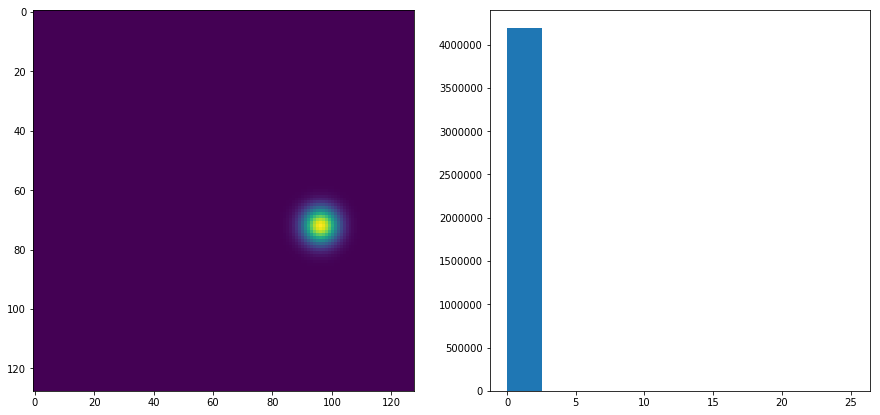

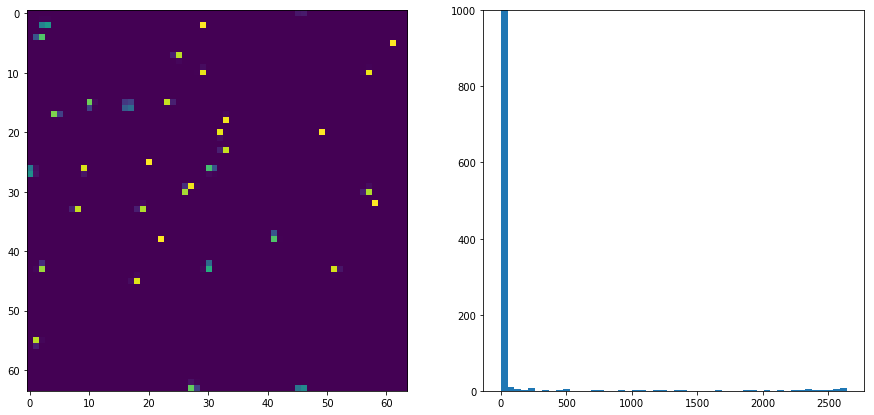

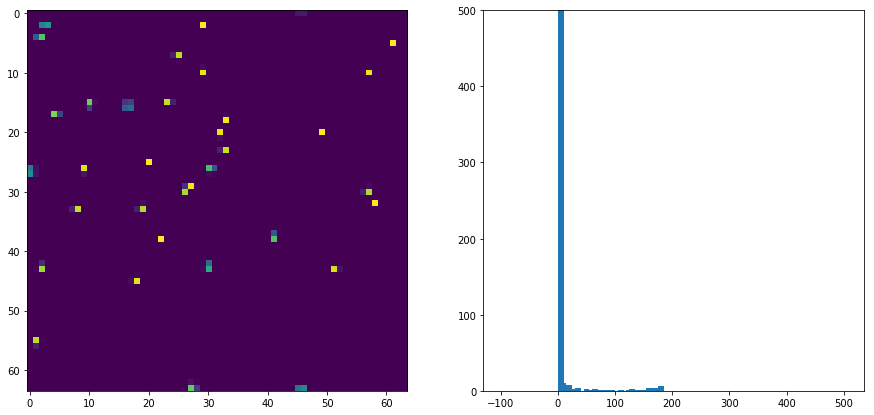

In [537]:
gridSize = [2048,2048]
detectorSize = [64,64]
kbar = 0.01
speckleSize = 50
chargeCloudSize = 0.3
photonEnergy = 9500
readoutNoise = 0

kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0]

tic = time.time()
speckle = makeSpeckle(gridSize, speckleSize)
speckleN = AddShotNoise(speckle, kbar_grid)
speckleNE = ApplyChargeCloud(speckleN, chargeCloudSize_grid, photonEnergy)
speckleD = rebin(speckleNE, detectorSize)
#speckleD = rebin_slow(speckleNE, 8)
speckleDD = digitizeCharge(speckleD)
speckleDN = AddReadoutNoise(speckleDD, readoutNoise)
toc = time.time();print(toc-tic)

print(sum(speckleN.flatten()))
print(sum(speckleNE.flatten())/photonEnergy*3.6)
print(sum(speckleD.flatten())/photonEnergy*3.6)
print(sum(speckleDD.flatten())/photonEnergy*3.6*15)
print(sum(speckleDN.flatten())/photonEnergy*3.6*15)

if False:
    plt.figure(figsize=[15,7]);plt.clf();
    plt.subplot(1,2,1);
    plt.imshow(speckle)
    plt.subplot(1,2,2);
    plt.hist(speckle.flatten())

    # charge distribution
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleNE[0:128,0:128])
plt.subplot(1,2,2);
plt.hist(speckleNE.flatten())

# pixel charge distribution
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleD)
plt.subplot(1,2,2);
plt.hist(speckleD.flatten(), 50)
plt.ylim(0,1000)

# final pattern
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleDN)
plt.subplot(1,2,2);
binWidth = 5;
bins = np.arange(-100, 500.1, binWidth)
histFinal = np.histogram(speckleDN.flatten(), bins)
plt.bar(bins[1:], histFinal[0], width=10)
plt.ylim(0,500)
plt.show()
    



In [599]:
def makeWeakSpeckle(kbar, speckleSize = 50, gridSize=[1024,1024], detectorSize=[128,128], chargeCloudSize=2,
                    photonEnergy=9500, readoutNoise=10):
    """
    use the functions in the earlier section to produce a single detector image of
    a weak speckle pattern with average signal rate of kbar.
    """
    kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
    chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0]
    print chargeCloudSize_grid
    speckle = makeSpeckle(gridSize, speckleSize)
    speckleN = AddShotNoise(speckle, kbar_grid)
    speckleNE = ApplyChargeCloud(speckleN, chargeCloudSize_grid, photonEnergy)
    speckleD = rebin(speckleNE, detectorSize)
    speckleDD = digitizeCharge(speckleD)
    return AddReadoutNoise(speckleDD, readoutNoise)

def makeFlatPoisson(kbar, gridSize=[1024,1024], detectorSize =[128,128], chargeCloudSize=2.0, photonEnergy=9500.0,
                    readoutNoise=10.0):
    
    chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0]
    kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
    pattern = np.ones(gridSize)
    patternN = AddShotNoise(pattern, kbar_grid)
    patternNE = ApplyChargeCloud(patternN, chargeCloudSize_grid, photonEnergy)
    patternD = rebin(patternNE, detectorSize)
    patternDD = digitizeCharge(patternD)
    return AddReadoutNoise(patternDD, readoutNoise)

In [579]:
a = np.random.poisson(np.ones([4,4])*0.2)
b = ApplyChargeCloud(a, 1, 1)
print(sum(a.flatten()))
print(sum(b.flatten())*3.6)

1
1.0


In [628]:
binWidth = 10;
bins = np.arange(-100, 1000.1, binWidth)
histFinal = np.zeros(np.shape(bins)[0]-1)
nPhoton = 0
kbar = 0.1
ccs=0.4
rn=3

N = 200
for i in range(N):
    if np.mod(i,10) == 0:
        print i
    #speckle = makeWeakSpeckle(kbar, chargeCloudSize=ccs, readoutNoise=rn)
    speckle = makeFlatPoisson(kbar, chargeCloudSize=ccs, readoutNoise=rn, detectorSize=[64,64])
    nPhoton += (sum(speckle.flatten())/9500*3.6*15);
    histHere = np.histogram(speckle.flatten(), bins)
    histFinal +=histHere[0]
print('DONE\n');
print('total number of photons: %d\n' % nPhoton)
print('simulated kbar: %.6f\n' % (nPhoton/128/128/N))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
DONE

total number of photons: 82134

simulated kbar: 0.025066



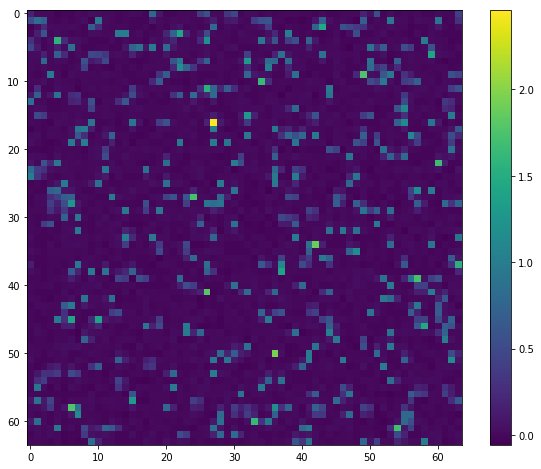

0.0247581761713


In [629]:
plt.figure(figsize=[10,8]);plt.clf();
plt.imshow(speckle/9500*3.6*15)
plt.colorbar()
plt.show()
print(sum(speckle.flatten())/9500*3.6*15/128/128)

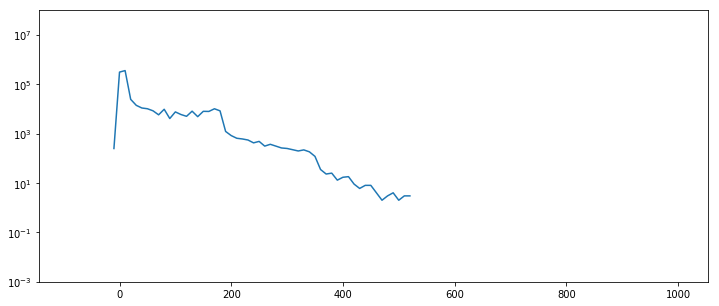

In [630]:
# take a look at the histogram  


plt.figure(figsize=[12,5]);plt.clf();
plt.semilogy(bins[1:], histFinal)
plt.ylim(1e-3,1e8)
plt.show()


In [283]:
import multiprocessing as mp

def PhotonHistBatch(N):
    """generate a histogram from 100 images"""
    binWidth = 10;
    bins = np.arange(-100, 1000.1, binWidth)
    histFinal = np.zeros(np.shape(bins)[0]-1, 20)

    for i in prange(N):
        if np.mod(i,10) == 0:
            print i
        speckle = makeWeakSpeckle(0.03, chargeCloudSize=5, readoutNoise=10)
        histHere = np.histogram(speckle.flatten(), bins)
        histFinal +=histHere[0]      
    return histFinal

def main():
    pool = mp.Pool(4)
    result = pool.map(PhotonHistBatch, [20,20,20,20])
    
if __name__ == "__main__":
    main()

TypeError: data type not understood

In [281]:
import multiprocessing as mp

def my_func(x):
  print(x**x)
  return x**x

def main():
  pool = mp.Pool(mp.cpu_count())
  result = pool.map(my_func, [4,2,3])
  print result

if __name__ == "__main__":
  main()

27
256
4
[256, 4, 27]


In [506]:
n = np.ones([8,8])
nr = rebin(n,[2,2])
print n
print nr

[[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]
[[ 16.  16.]
 [ 16.  16.]]


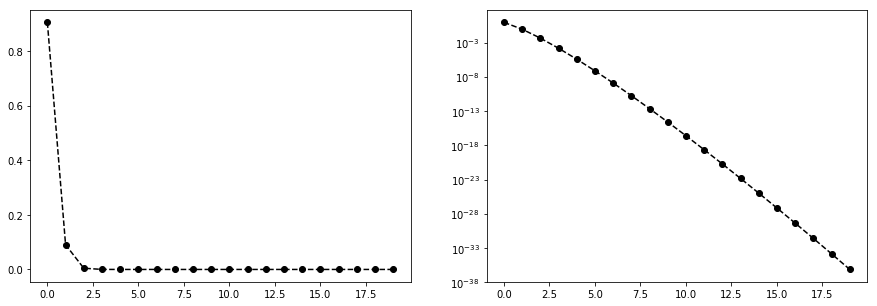

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2]
 [ 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4
   0.4]
 [ 0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6
   0.6]
 [ 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8
   0.8]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1. ]
 [ 1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2
   1.2]
 [ 1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4
   1.4]
 [ 1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6
   1.6]
 [ 1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8
   1.8]
 [ 2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2. ]
 [ 2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2
   2.2]
 [ 2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4

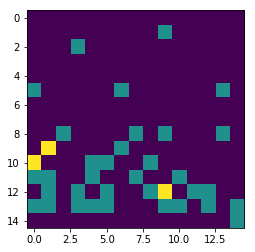

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 2 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [2 0 0 0 1 1 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 1 0 0 1 0 0 0 0]
 [0 1 0 1 0 1 0 0 1 2 0 1 1 0 0]
 [1 1 0 1 1 1 0 0 0 1 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [67]:
"""test generating poission probabilities ... seems good for small k expectation values,
and some numerical divergence when go to bigger values than 20.
if we use np.random.choice, we need to provide the poission probability distribution, or we can use the build in
poission random function."""

import numpy as np
from scipy.special import factorial
from matplotlib import pyplot as plot
k = np.arange(20)
k_expectation = 0.1
poisson_dist = np.exp(-k_expectation)*(k_expectation**k)/factorial(k);

plt.figure(figsize = [15,5]);plt.clf;
plt.subplot(1,2,1)
plt.plot(poisson_dist, '--ok')
plt.subplot(1,2,2)
plt.semilogy(poisson_dist, '--ok')
plt.show()

# now use the built in function
a = np.mgrid[0:3:0.2,0:3:0.2]
print a[0]
ar = np.random.poisson(a[0]*0.1)

plt.figure();
plt.imshow(ar)
plt.show()
print ar